# Predicting S&P 500 Closing Prices

The project is an attempt to predict closing prices of the S&P 500 using historical data dating back to the 1950s. The goal of the project is to minimize the error metric as much as possible. I'm doing this for practice, and not for implementation. Even if the predictions are fairly accurate, the results will likely not generalize well to external data, so if anyone has stumbled upon this hoping to use it for investment, DON'T! 

# Introducing the Data

In [1]:
import pandas as pd
import numpy as np
import datetime 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

stocks = pd.read_csv('sphist.csv')

print(stocks.shape)
stocks.head()

(16590, 7)


,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883


The data consists of 16590 stock records from the S&P500. The seven columns are described below:


- Date: The date of the record.
- Open: The opening price of the day (when trading starts).
- High: The highest trade price during the day.
- Low: The lowest trade price during the day.
- Close: The closing price for the day (when trading is finished).
- Volume: The number of shares traded.
- Adj Close: The daily closing price, adjusted retroactively to include any corporate actions.

For the purpose of this mission, we'll be constructing a number of indicator columns from existing column data. We'll use the Close column as the prediction target.

# Feature Selection

In [2]:
# Convert values in 'Date' column to datetime objects
stocks['Date'] = pd.to_datetime(stocks['Date'])

# Sort dataframe by date
stocks.sort_values('Date', ascending=True, inplace=True)

stocks.head()

,Date,Open,High,Low,Close,Volume,Adj Close
16589,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
16588,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
16587,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
16586,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
16585,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


In [3]:
# Indicator 1: average (avg) price for past 5 days
stocks['avg_day_5'] = stocks['Close'].shift(1).rolling(5).mean()

# Indicator 2: standard deviation (std) of the price over the past 5 days
stocks['std_day_5'] = stocks['Close'].shift(1).rolling(5).std()

# Indicator 3: avg price for past 30 days
stocks['avg_day_30'] = stocks['Close'].shift(1).rolling(30).mean()

# Indicator 4: std price for past 30 days
stocks['std_day_30'] = stocks['Close'].shift(1).rolling(30).std()

# Indicator 5: avg price for past 365 days
stocks['avg_day_365'] = stocks['Close'].shift(1).rolling(365).mean()

# Indicator 6: std price for past 365 days
stocks['std_day_365'] = stocks['Close'].shift(1).rolling(365).std()

# Indicator 7: ratio of average price from last 5 days to average price from last 365 days
stocks['avg_day_5_to_365'] = stocks['avg_day_5']/stocks['avg_day_365']

# Indicator 8: avg price past 30 days / avg price past 365 days
stocks['avg_day_30_to_365'] = stocks['avg_day_30']/stocks['avg_day_365']

# Indicator 9: std price past 5 days / std past 365 days
stocks['std_day_5_to_365'] = stocks['std_day_5']/stocks['std_day_365']

# Indicator 10: std price past 30 days / std past 365 days
stocks['std_day_30_to_365'] = stocks['std_day_30']/stocks['std_day_365']

# Indicator 11: year
stocks['year'] = pd.DatetimeIndex(stocks['Date']).year

# Indicator 12: day
stocks['day'] = pd.DatetimeIndex(stocks['Date']).day

There are probably far too many indicators here for the model to be reliable. I've only constructed all of these columns for now so that I can experiment with them and eliminate those that don't work well. In the future we probably want to normalize the features because the error metrics here may be misleading with the data in its current state.

In [4]:
# Remove columns without enough historical data for calculations
stocks.dropna(axis=0, inplace=True)

# Building the Model

For now, we'll split the data into a training set consisting of all data prior to 2013 and a test set consisting of all data post 2013. The original dataset spans from the 1950s to 2015. A test set with two years of data is probably not the best choice for stock predictions, but we'll use that timespan for now and then shorten it to a single day later.

In [5]:
# Split data into train and test sets
train = stocks[stocks['Date'] < datetime.datetime(year=2013, month=1, day=1)]
test = stocks[stocks['Date'] >= datetime.datetime(year=2013, month=1, day=1)]

# Initiate Linear Regression model
model = LinearRegression()

# Set features and target column
target = 'Close'
features = train.drop(columns = ['Close', 
                                'High', 
                                'Low', 
                                'Open', 
                                'Volume', 
                                'Adj Close', 
                                'Date']
                     ).columns

# Fit model
model.fit(train[features], train[target])

# Make predictions
predictions = model.predict(test[features])

# Calculate error metrics
mae = mean_absolute_error(test[target], predictions)
mse = mean_squared_error(test[target], predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test[target], predictions)

print('MAE: {0} \nMSE: {1} \nRMSE: {2} \nR2: {3}'.format(mae, mse, rmse, r2))

MAE: 16.243928008109048 
MSE: 493.5492954594102 
RMSE: 22.21596937924182 
R2: 0.9866476448205508


Using all of the indicators constructed above, we have a mean absolute error of approximately 16.2, and a root mean square error of approximately 22.2. The difference between the RMSE and MAE is not incredibly large, so though there is some variation in the magnitude of errors, there don't appear to be large inconsistencies in the predictions. We can accept then that the average difference between the predicted closing value and the actual closing value was approximately 16.2 dollars. Our R^2 value indicates that the regression line closely fits the data, but we should visualize our residuals to make sure we actually have a good fit.

# Visualizing

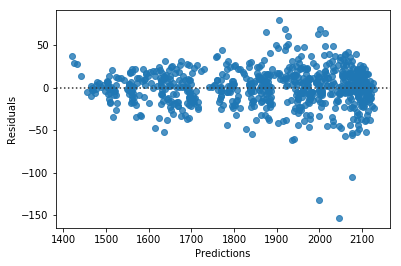

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.residplot(predictions, test[target])
plt.xlabel('Predictions')
plt.ylabel('Residuals')

plt.show()

There are a few outliers worth exploring. It may not be a big deal, since the residual plot otherwise shows a random distribution, but let's explore them anyway.

In [7]:
residuals = test[target] - predictions

# Isolating outliers
test.iloc[residuals[residuals < -100].index]

,Date,Open,High,Low,Close,Volume,Adj Close,avg_day_5,std_day_5,avg_day_30,std_day_30,avg_day_365,std_day_365,avg_day_5_to_365,avg_day_30_to_365,std_day_5_to_365,std_day_30_to_365,year,day
664,2013-04-19,1541.609985,1555.890015,1539.400024,1555.250000,3.569870e+09,1555.250000,1561.879980,19.282993,1560.449320,12.709326,1392.452327,90.806416,1.121676,1.120648,0.212353,0.139961,2013,19
665,2013-04-18,1552.030029,1554.380005,1536.030029,1541.609985,3.890800e+09,1541.609985,1572.231982,19.572071,1560.444320,12.717021,1391.566492,90.924353,1.129829,1.121358,0.215257,0.139864,2013,18
666,2013-04-17,1574.569946,1574.569946,1543.689941,1552.010010,4.250310e+09,1552.010010,1579.375976,16.645873,1560.036987,13.183637,1390.748108,90.820522,1.135631,1.121725,0.183283,0.145161,2013,17


Hmm... No idea why these three entries are so poorly predicted in comparison to the others. I'll dig into this more later. It's only three values, so I'm not too worried about their affect on the model. Let's see how the model does without them.

In [8]:
residuals = test[target] - predictions

new_test = test.drop(residuals[residuals < -100].index)

# Initiate Linear Regression model
model = LinearRegression()

# Set features and target column
target = 'Close'
features = train.drop(columns = ['Close', 
                                'High', 
                                'Low', 
                                'Open', 
                                'Volume', 
                                'Adj Close', 
                                'Date']
                     ).columns

# Fit model
model.fit(train[features], train[target])

# Make predictions
new_predictions = model.predict(new_test[features])

# Calculate error metrics
mae = mean_absolute_error(new_test[target], new_predictions)
mse = mean_squared_error(new_test[target], new_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(new_test[target], new_predictions)

print('MAE: {0} \nMSE: {1} \nRMSE: {2} \nR2: {3}'.format(mae, mse, rmse, r2))

MAE: 15.781378098127764 
MSE: 425.37780568197337 
RMSE: 20.624689226312558 
R2: 0.9885346182689938


The performance of the model has improved after dropping those entries. It's not a huge improvement, but I think it may warrant more investigation.

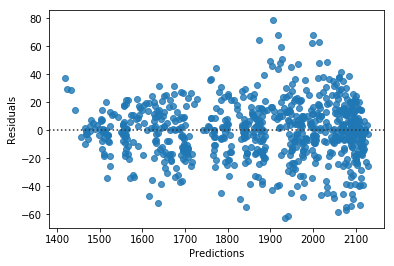

In [9]:
sns.residplot(new_predictions, new_test[target])
plt.xlabel('Predictions')
plt.ylabel('Residuals')

plt.show()

The residual plot suggests a good fit.

# Notes

This project was conducted to practice linear regression on a dataset. The analysis of the model and its performance at this juncture is tentative and will hopefully improve as I learn more on the subject. As it stands, anybody who stumbles upon this should ABSOLUTELY NOT consult this model hoping for investment advice.

### Steps for the future

- Eliminate redundant features
- More robust feature selection
- Instead of predicting years in advance, try to predict one day ahead
- Make plots prettier